In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch

import copy
import random

/home/user1-asd-arch/.local/share/virtualenvs/code-b8C0A6mP/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def create_dataset(df, shuffle=True):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  if shuffle: 
    random.Random(6).shuffle(dataset)

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

In [3]:
df = pd.read_csv("data/mit_bih.csv", index_col=0)
df.head()

,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,...,t_170,t_171,t_172,t_173,t_174,t_175,t_176,t_177,t_178,t_179
0,0.572289,0.572289,0.572289,0.575904,0.575904,0.575904,0.571084,0.569880,0.572289,0.574699,...,0.557831,0.559036,0.559036,0.556627,0.555422,0.551807,0.551807,0.555422,0.555422,0.553012
1,0.574699,0.574699,0.575904,0.578313,0.578313,0.578313,0.574699,0.574699,0.577108,0.578313,...,0.566265,0.566265,0.567470,0.563855,0.562651,0.557831,0.560241,0.563855,0.563855,0.565060
2,0.583133,0.585542,0.586747,0.587952,0.586747,0.584337,0.579518,0.580723,0.585542,0.589157,...,0.561446,0.562651,0.561446,0.559036,0.556627,0.557831,0.560241,0.562651,0.562651,0.561446
3,0.571084,0.568675,0.567470,0.567470,0.566265,0.571084,0.568675,0.569880,0.567470,0.568675,...,0.551807,0.550602,0.556627,0.556627,0.556627,0.556627,0.550602,0.554217,0.555422,0.554217
4,0.569880,0.568675,0.572289,0.571084,0.568675,0.568675,0.568675,0.572289,0.572289,0.571084,...,0.557831,0.556627,0.554217,0.549398,0.554217,0.554217,0.557831,0.556627,0.553012,0.550602


In [4]:
df.iloc[0]

t_0      0.572289
t_1      0.572289
t_2      0.572289
t_3      0.575904
t_4      0.575904
           ...   
t_175    0.551807
t_176    0.551807
t_177    0.555422
t_178    0.555422
t_179    0.553012
Name: 0, Length: 180, dtype: float64

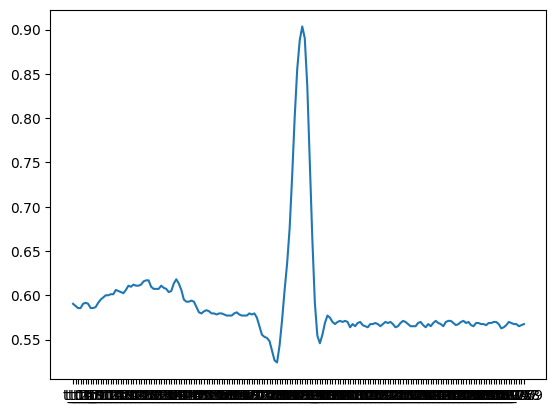

In [5]:
plt.plot(df.iloc[234,:])

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
def train_model(model, train_dataset, val_dataset, n_epochs, lr):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  criterion = torch.nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [8]:
dataset,seq_len, n_feat = create_dataset(df)

In [9]:
dataset[0]

tensor([[0.6000],
        [0.6012],
        [0.6048],
        [0.6036],
        [0.6000],
        [0.6000],
        [0.6012],
        [0.6024],
        [0.6012],
        [0.6000],
        [0.5964],
        [0.5952],
        [0.5976],
        [0.6024],
        [0.6048],
        [0.6036],
        [0.6048],
        [0.6048],
        [0.6072],
        [0.6145],
        [0.6157],
        [0.6157],
        [0.6120],
        [0.6133],
        [0.6193],
        [0.6205],
        [0.6217],
        [0.6205],
        [0.6241],
        [0.6217],
        [0.6265],
        [0.6277],
        [0.6289],
        [0.6253],
        [0.6229],
        [0.6193],
        [0.6181],
        [0.6229],
        [0.6229],
        [0.6193],
        [0.6157],
        [0.6145],
        [0.6193],
        [0.6265],
        [0.6277],
        [0.6193],
        [0.6108],
        [0.6048],
        [0.6048],
        [0.6048],
        [0.6012],
        [0.6000],
        [0.5976],
        [0.5928],
        [0.5940],
        [0

In [10]:
dataset = dataset[0:5000]

In [11]:
from lstmae import RecurrentAutoencoder

model = RecurrentAutoencoder(seq_len, n_feat, device, 128)
model = model.to(device)
model

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 256, batch_first=True)
    (rnn2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(128, 128, batch_first=True)
    (rnn2): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [12]:
train_ratio = 0.7
test_ratio = 0.1
train_index = int(len(dataset)*train_ratio)
test_index = int(len(dataset)*test_ratio) + train_index
train = dataset[0:train_index]
test = dataset[train_index:test_index]
val = dataset[test_index::]
assert len(train)+len(test)+len(val) == len(dataset)

In [13]:
model, history = train_model(
  model, 
  train_dataset=train, 
  val_dataset=val, 
  n_epochs=20,
  lr=1e-2
)

Epoch 1: train loss 8.095197120870862 val loss 4.570648019075394
Epoch 2: train loss 6.140729051726205 val loss 4.474429612636566
Epoch 3: train loss 6.066187230723245 val loss 4.630044482707977
Epoch 4: train loss 5.967013066768646 val loss 4.911952033996582
Epoch 5: train loss 6.065726082052503 val loss 4.827156135320664
Epoch 6: train loss 6.03094591992242 val loss 4.669893185377121
Epoch 7: train loss 5.961962776933397 val loss 5.020297659397126
Epoch 8: train loss 5.791603078978402 val loss 4.4978244407176975
Epoch 9: train loss 5.719635787010193 val loss 5.100158972978592
Epoch 10: train loss 5.822277328218733 val loss 5.972427594184875
Epoch 11: train loss 5.711576251643044 val loss 4.717722195148468
Epoch 12: train loss 5.726840373107366 val loss 6.753239604234696
Epoch 13: train loss 5.66542803818839 val loss 4.554942609786988
Epoch 14: train loss 5.737139183998108 val loss 6.12031285238266
Epoch 15: train loss 5.741015915461949 val loss 4.599425235748291
Epoch 16: train loss 

In [15]:
torch.save(model, "models/lstmae_5000")

In [85]:
model = model.to(device="cpu")

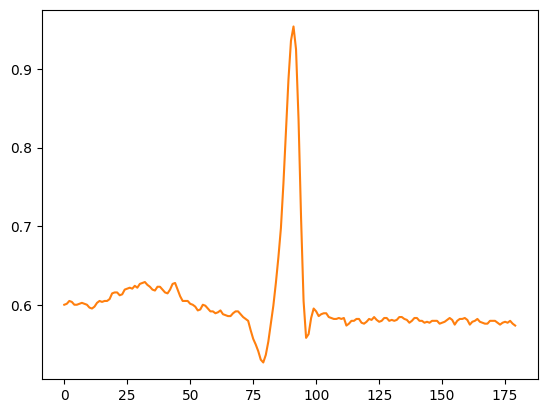

In [86]:
plt.plot(model(dataset[0]).detach().numpy().squeeze())
plt.plot(dataset[0].detach().numpy().squeeze())